In [35]:
"""input central density value
calculate central pressure
use as p0 for HSE equations
"""

'input central density value\ncalculate central pressure\nuse as p0 for HSE equations\n'

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11  # Gravitational constant in N*m^2/kg^2
M_sun = 1.989e30  # Solar mass in kg
R_sun = 6.955e8  # Solar radius in m
#K_NR = 1.2435e15  # Constant for non-relativistic electron degenerate gas (cgs units)
m_e = 9.11e-31 #Electron mass in kg
hbar = 1.05457182e-34 #Reduced Planck constant in Js^-1
c = 2.99e8 #Speed of light in ms^-1
a_z = 2
m_n = 1.67e-27 #Neutron mass in kg

In [37]:
def K_NR():
    """Inverse EOS to get density from pressure for non-relativistic case"""
    return (hbar**2  / (15 * np.pi**2 * m_e) * (3 * np.pi**2 / (a_z * m_n * c**2))**(5/3))

def K_R():
    """Inverse EOS to get density from pressure for relativistic case"""
    return (hbar* c)/ (12 * np.pi**2)  * (3 * np.pi**2 / (a_z * m_n * c**2))**(4/3)


def calc_rho(P,K):
    if K == K_NR:
        n = 5/3
    else:
        n=4/3

    if P.any()<0:
        return 0
    else:
        return (P/K())**(1/n) / c**2

def calc_p(rho, K):
    if K == K_NR:
        n = 5/3
        return K() * (rho * c**2)**(n)
    else:
        n=4/3
        return K() * (rho * c)**(2*n)

    
   





In [38]:
K_R()
K_NR()

1.751714011328775e-22

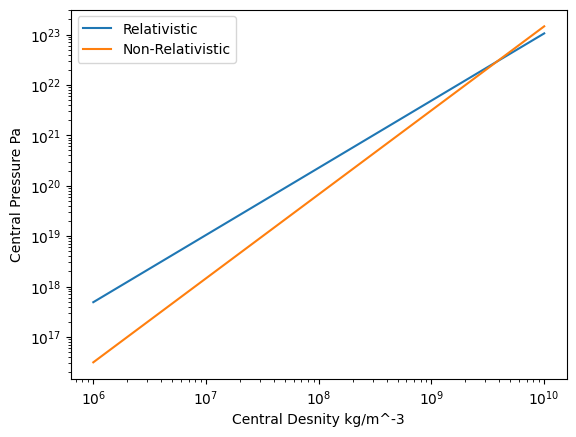

In [39]:
p0R = calc_p0(np.logspace(4,5,10), K_R)
p0NR = calc_p0(np.logspace(4,5,10), K_NR)

rho_range = np.logspace(6,10,100)

plt.plot(rho_range, calc_p0(rho_range, K_R), label="Relativistic")
plt.plot(rho_range, calc_p0(rho_range, K_NR), label="Non-Relativistic")
plt.xlabel("Central Desnity kg/m^-3")
plt.ylabel("Central Pressure Pa")
plt.loglog()
plt.legend()
plt.show()



In [40]:
# ----------------- Structure Solver -----------------
def hydrostatic_equilibrium(r, y, K):
    """Equation for hydrostatic equilibrium: y[0]=Pressure, y[1]=Mass"""
    P, M = y
    rho = rho_from_pressure(P, K)  # Calculate density from pressure

    dP_dr = (-G * M * rho) / (r**2)
    dM_dr = 4 * np.pi * r**2 * rho
    return [dP_dr, dM_dr]

In [41]:
# ----------------- Event to Stop at Pressure < threshold -----------------
def stop_at_pressure_threshold(r, y, K):
    threshold_pressure = 1e-3  # Define a small threshold for pressure
    return y[0] - threshold_pressure  # Stop when pressure y[0] < threshold_pressure
stop_at_pressure_threshold.terminal = True  # Stop integration when this condition is met
stop_at_pressure_threshold.direction = -1   # Trigger only when pressure is decreasing

# ----------------- Main Integration Function -----------------
def integrate_star(central_pressure,K):
    """Solve the structure equations numerically"""
    radius = 1e11
    
    sol = solve_ivp(
        hydrostatic_equilibrium, 
        [1e-6, radius], 
        [central_pressure, 0],
        method='RK45',
        events=stop_at_pressure_threshold, 
        dense_output=True, 
        max_step=1e5, 
        args=(K,))
    
    return sol.t, sol.y[0], sol.y[1]  # Return radius, pressure, and mass profiles


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def pressure_mass_single_star_plot(central_density, K_NR, K_R):
    # Define consistent colors for each model
    color_NR = 'orange'  # Color for K_NR
    color_R = 'blue'     # Color for K_R

    # Calculate initial pressure for both cases
    p0_NR = calc_p(central_density, K_NR)
    p0_R = calc_p(central_density, K_R)
    
    # Create a figure with three subplots arranged vertically
    plt.figure(figsize=(10, 15))

    # Integrate star structure to get radius, pressure, and mass for K_NR
    radius_NR, pressure_NR, mass_NR = integrate_star(p0_NR, K_NR)
    # Integrate star structure to get radius, pressure, and mass for K_R
    radius_R, pressure_R, mass_R = integrate_star(p0_R, K_R)

    # Normalize radius and mass
    radius_solar_NR = radius_NR / R_sun  # Convert radius to solar radii
    radius_solar_R = radius_R / R_sun     # Convert radius to solar radii
    total_mass_NR = mass_NR[-1] # Total mass in solar masses for K_NR
    total_mass_R = mass_R[-1]    # Total mass in solar masses for K_R

    # Normalized radius and mass
    norm_radius_NR = radius_solar_NR / radius_solar_NR[-1]  # Normalize radius by the last value (total radius)
    norm_radius_R = radius_solar_R / radius_solar_R[-1]    # Normalize radius by the last value (total radius)
    norm_mass_NR = mass_NR / total_mass_NR                   # Normalize mass
    norm_mass_R = mass_R / total_mass_R                       # Normalize mass
    
    # Calculate density from pressure for both cases
    density_NR = calc_rho(pressure_NR, K_NR)  # Calculate density from pressure
    density_R = calc_rho(pressure_R, K_R)     # Calculate density from pressure

    # Plot 1: Normalized Mass as a function of normalized radius
    plt.subplot(3, 1, 1)  # Three rows, one column, first subplot
    plt.plot(norm_radius_NR, norm_mass_NR, label="Normalized Mass (K_NR)", color=color_NR)
    plt.plot(norm_radius_R, norm_mass_R, label="Normalized Mass (K_R)", color=color_R)
    plt.ylabel("Normalized Mass")
    plt.title("Normalized Mass vs. Normalized Radius")
    plt.legend()
    plt.grid()

    # Plot 2: Pressure as a function of normalized radius
    plt.subplot(3, 1, 2)  # Three rows, one column, second subplot
    plt.plot(norm_radius_NR, pressure_NR, label="Pressure (K_NR)", color=color_NR)
    plt.plot(norm_radius_R, pressure_R, label="Pressure (K_R)", color=color_R)
    plt.ylabel("log P (Pa)")
    plt.yscale("log")  # Set y-axis to logarithmic scale
    plt.title("Pressure vs. Normalized Radius")
    
    # Customizing tick labels for logarithmic scale
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(np.log10(x))}'))

    plt.legend()
    plt.grid()

    # Plot 3: Density as a function of normalized radius (logarithmic scale)
    plt.subplot(3, 1, 3)  # Three rows, one column, third subplot
    plt.plot(norm_radius_NR, density_NR, label="Density (K_NR)", color=color_NR)
    plt.plot(norm_radius_R, density_R, label="Density (K_R)", color=color_R)
    plt.xlabel("Normalized Radius")
    plt.ylabel("log (density) (kg/m³)")
    plt.yscale("log")  # Set y-axis to logarithmic scale
    
    # Customizing tick labels for logarithmic scale
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(np.log10(x))}'))

    plt.title("Density vs. Normalized Radius")
    plt.legend()
    plt.grid()

    plt.tight_layout()  # Adjust layout to prevent overlap
    #plt.show()

    return total_mass_R, total_mass_NR




C:\Users\Lenovo ThinkPad\AppData\Local\Temp\ipykernel_5928\1822770601.py:19: RuntimeWarning: invalid value encountered in scalar power
  return (P/K())**(1/n) / c**2


1.4337130205340676


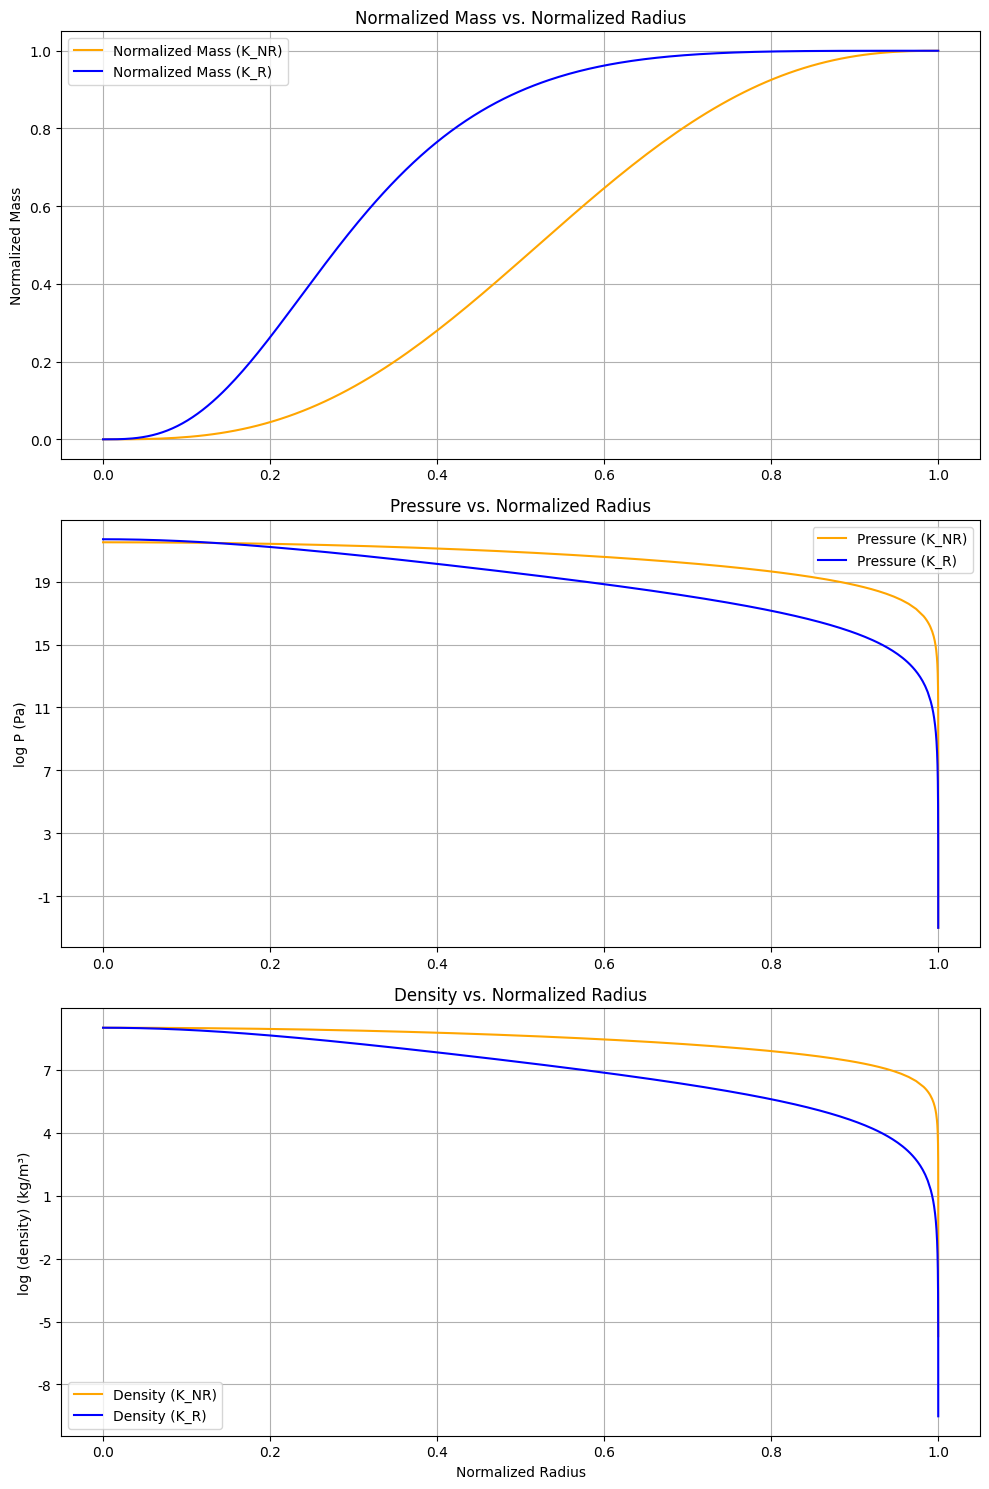

In [43]:
# Example usage
central_density = 10e8
total_mass_R, total_mass_NR = pressure_mass_single_star_plot(central_density, K_NR, K_R)

print(total_mass_R/M_sun)

C:\Users\Lenovo ThinkPad\AppData\Local\Temp\ipykernel_5928\1822770601.py:19: RuntimeWarning: invalid value encountered in scalar power
  return (P/K())**(1/n) / c**2


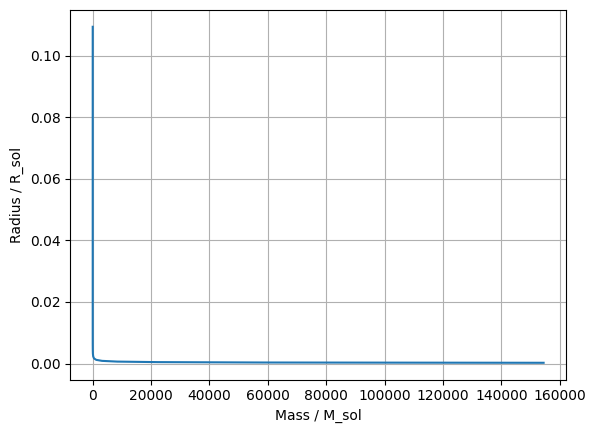

In [44]:
####Multiple Star

def plot_mass_radius_relation(rho_0s,K):

    radii = []
    masses = []

    for rho_0 in rho_0s:
        p0 = calc_p(rho_0,K)
        radius, pressure, mass = integrate_star(p0,K)
        radii.append(radius[-1]/R_sun)
        masses.append(mass[-1]/M_sun)

    plt.plot(masses,radii)
    plt.ylabel("Radius / R_sol")
    plt.xlabel("Mass / M_sol")
    #plt.ylim(0,0.036)
    plt.grid()


plot_mass_radius_relation(np.logspace(4,20,20),K_NR)
#plot_mass_radius_relation(np.logspace(7,15,20),K_R)




In [45]:

rho_0s = np.logspace(1,10, 10)
radii = []
masses = []

for rho_0 in rho_0s:
    p0 = calc_p0(rho_0,K_R)
    radius, pressure, mass = integrate_star(p0,K_R)
    radii.append(radius[-1]/R_sun)
    masses.append(mass[-1]/M_sun)


plt.plot(masses,radii)
print(radii)

plt.xlabel("mass")
plt.ylabel("radius")
plt.show()

In [ ]:
print(masses)

[1.4337130198321042, 1.433713017323653, 1.4337130205295445, 1.4337130205547877, 1.433713020807835, 1.4337130200576567, 1.433713016846317, 1.433713024978078, 1.433713664728352, 1.4337114217302769]


[15434781.91112326  7168243.88690743  3328042.92726872  1544931.53647129
   717120.98515522   332878.88116458   154510.24037498    71717.57891563
    33287.97482844    15451.07122262]


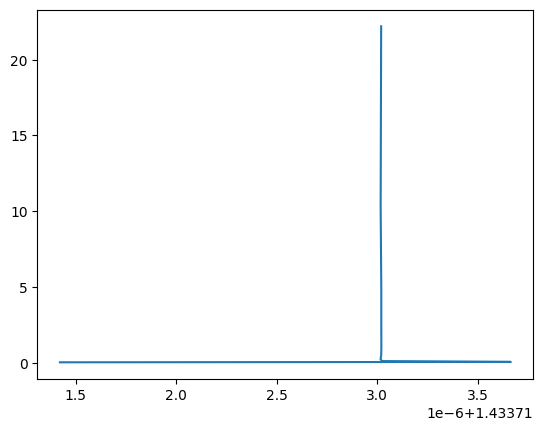

In [ ]:
d=41
plt.plot(masses[:d],radii[:d])
r = np.array(radii[:d])*R_sun / 1000
print(r)
